# **American Sign Language classification**

Выполнил: Касенов Султан

Проект ASL ​​Recognition включает в себя создание CNN с использованием PyTorch для классификации изображений американского языка жестов. Также проект включает в себя такие задачи, как визуализация и анализ данных, их подготовка к моделированию, обучение CNN на наборе данных изображений, а также проверка полученной модели на практике.


# **Предобработка датасета изображений и его визуализация**

Для начала импортируем все используемые библиотеки в данной работе. 


In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
from torchsummary import summary
import os
import re
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tqdm
import seaborn as sn
import pandas as pd

Чтобы удобно загружать изображения в модель мы будем пользоваться специальными dataloaders классами, которые есть в PyTorch. Для этого мы сначала разделим все наши изображения на тренировочную и тестовую части, создав отдельные дирректории и поместив туда все наши классы.

In [18]:
# Set the path to the directory containing the class directories
data_dir = '/Users/sultankasenov/Desktop/triplet'

# Get a list of the class directories
class_dirs = os.listdir(data_dir)

# Loop through each class directory and split the images into training and testing sets
for class_dir in class_dirs:
    
    # Set the path to the current class directory
    class_path = os.path.join(data_dir, class_dir)

    if class_path == '/Users/sultankasenov/Desktop/triplet/.DS_Store':
        continue
    
    # Get a list of the image files in the class directory
    image_files = os.listdir(class_path)
    
    # Split the image files into training and testing sets
    train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
    
    # Create new directories for the training and testing sets
    train_dir = os.path.join(data_dir, 'train', class_dir)
    test_dir = os.path.join(data_dir, 'test', class_dir)
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Move the training images to the new directory
    for train_file in train_files:
        src_path = os.path.join(class_path, train_file)
        dst_path = os.path.join(train_dir, train_file)
        shutil.copy(src_path, dst_path)
        
    # Move the testing images to the new directory
    for test_file in test_files:
        src_path = os.path.join(class_path, test_file)
        dst_path = os.path.join(test_dir, test_file)
        shutil.copy(src_path, dst_path)

Подготавливаем dataloaders и функцию предобработки, которая будет выполняться для каждого изображения в батче. Также сохраняем классы в новую переменную.

In [2]:
# define transform functions which should applied to images
transform = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# prepare loader for train data
trainset = torchvision.datasets.ImageFolder(root='/Users/sultankasenov/Desktop/triplet/train', transform=transform )
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=True)

# prepare loader for test data
testset = torchvision.datasets.ImageFolder(root='/Users/sultankasenov/Desktop/triplet/test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)

# save all classes to list
classes = os.listdir('/Users/sultankasenov/Desktop/triplet')

Далее, отсортируем список классов (чтобы был такой же порядок как и в директориях), удалим лишние классы и сохраним их в виде кортежа.

In [3]:
classes.remove('.DS_Store')
classes.remove('test')
classes.remove('train')
classes.sort()
classes = tuple(classes)
classes

('A', 'B', 'C')

Теперь проиллюстрируем один батч изображений. Ниже представлены сами изображения в виде списка, а также расшифровка жестов сверху в соответствующем порядке.

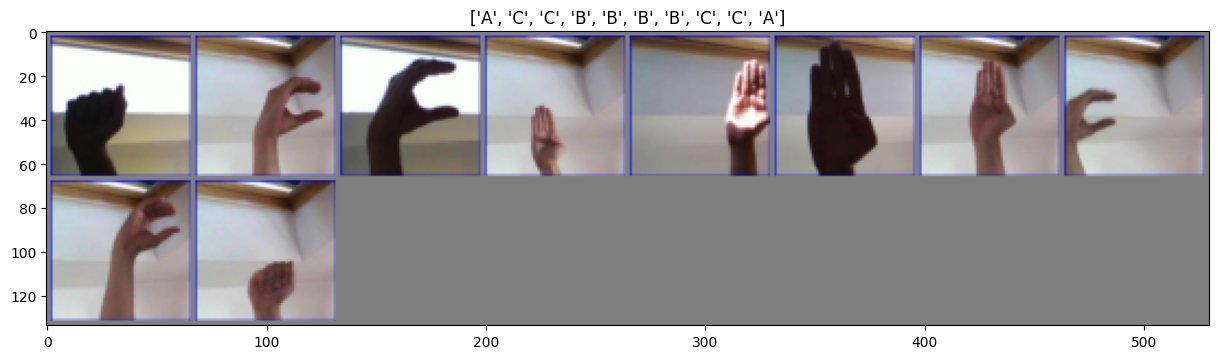

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize = (15,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes_id = next(iter(trainloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in classes_id])

# **Transfer learning with VGG16**

Чтобы обучить модель с хорошей точностью, мы используем уже обученную модель *VGG16*. Однако перед тем как оценивать точность, следует изменить архитектуру нейросети так, чтобы она имела кол-во выходов, равное кол-во классов, а также следует до обучить ее на новом датасете.

Далее мы скачиваем обученную модель.

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/sultankasenov/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:13<00:00, 7.67MB/s]


Переходим с CPU на GPU.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Перед тем как менять архитектуру нейросети мы уберем возможность вычислять градиенты для весов. Чтобы в будущем при обучении на собственном датасете менять веса только измененной нами части.

In [ ]:
for param in model1.parameters():
    param.requires_grad = False

В VGG16 последний полносвязный слой называется *classifier*. Поэтому мы 
меняем его на новый слой, представленный ниже. Главная особенность - это новое кол-во выходов.

In [ ]:
model1.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(4096, 35)
    )

Пропишем функции *validate* и *train*. Первая нужна чтобы выводить точность нейросети на тестовом датасете, второй метод запускает циклы обучения нейросети.

In [ ]:
print(f'Using device={device}')

def validate(net,test_loader):
  count=acc=0
  for xo,yo in test_loader:
    x,y = xo.to(device), yo.to(device)
    with torch.no_grad():
      p = net.forward(x)
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
  return acc/count

def train(net,train_loader,test_loader,epochs=3,loss_fn=torch.nn.CrossEntropyLoss()):
  net = net.to(device)
  optimizer = torch.optim.Adam(net.parameters())
  for ep in range(epochs):
    count=acc=0
    for xo,yo in train_loader:
      x = xo.to(device)
      y = yo.to(device)
      optimizer.zero_grad()
      p = net.forward(x)
      loss = loss_fn(p,y)
      loss.backward()
      optimizer.step()
      _,predicted = torch.max(p,1)
      acc+=(predicted==y).sum()
      count+=len(x)
    val_acc = validate(net,test_loader)
    print(f"Epoch={ep}, train_acc={acc/count}, val_acc={val_acc}")

Using device=cpu


In [ ]:
train(model, trainloader, testloader, 3)

# **Remote learning**

Однако здесь стоит отметить, что для дальнейшей работы с камерой требуется запустить данный ноутбук локально на своем компьютере. Это связано с тем, что код запуска камеры в Google Colab совершенно другой и это создает лишние проблемы. Поэтому я обучил модель в облачной среде Google Colab, так как не имею GPU на своем компьютере и сохранил ее на своем компьютере. Код при обучении не менялся. Во-вторых, была проблема загрузки датасета в Google Colab, связанная с размером загружаемых данных. И поэтому я использовал для обучения только три класса жестов, чтобы снизить размер датасета. 

Сейчас загрузим сохраненный файл нейросети. 

In [4]:
model = torch.load('VGG_triplet_099.pt', map_location=torch.device('cpu'))

Оценим точность загруженной модели, которая была равна 99 процентам с помощью матрицы ошибок. 

<Axes: >

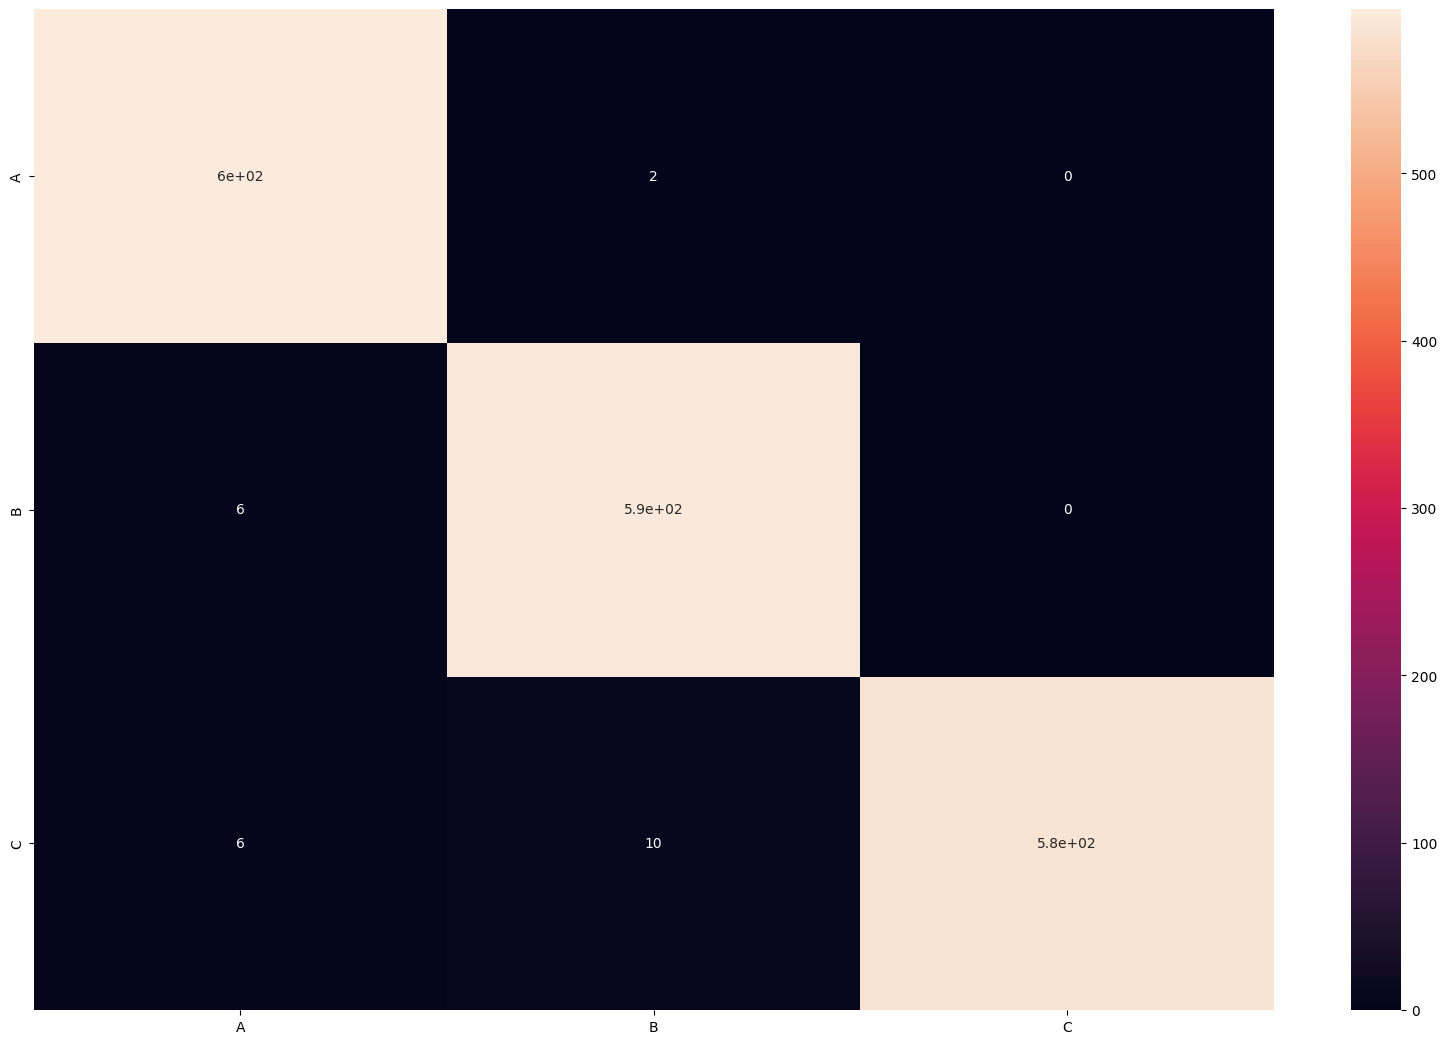

In [30]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
  
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])

# plot the matrix
plt.figure(figsize = (20,13))
sn.heatmap(df_cm, annot=True)

# **Hand detection with mediapipe**

Теперь после того как мы обучили модель классифицировать жесты, нужно научиться находить данный жест на кадре и подавать его в модель чтобы в реальном времени предсказывать какой жест мы показываем. Это нужно чтобы модель не отвлекалась на посторонние предметы на кадре. Более того модель обучалась также на вырезанных жестах руки поэтому будет логично подавать ей на вход только сам жест руки. 

Чтобы выполнить object detection часть данной работы мы используем библиотеку **mediapipe**, которая сделает все за нас. Для начала установим ее.

In [ ]:
!pip install mediapipe opencv-python

Данная библиотека имеет очень удобную документацию и там есть готовые части кода для самых разных задач. Поэтому мы воспользуемся готовым решением и если перейти по данной [ссылке](https://google.github.io/mediapipe/solutions/hands) можно увидеть полное объяснение того как все работает. После этого остается добавить модель, которая будет получать вырезанный кадр руки и выдавать результат. Мы будем использовать полученные числа, чтобы вывести на экран правильный класс жеста. 

In [ ]:
import cv2
import mediapipe as mp
from PIL import Image


mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands


# For webcam input:
cap = cv2.VideoCapture(0)
with mp_hands.Hands(
    model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:
  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)
    
    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    # Determine the bounding box that encompasses the hand
    x_min, y_min, x_max, y_max = None, None, None, None
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks: 
        
        # Here is How to Get All the Coordinates
            for ids, landmrk in enumerate(hand_landmarks.landmark):
                x, y = landmrk.x * image.shape[1], landmrk.y*image.shape[0]
            
                if x_min is None or x < x_min:
                    x_min = int(x)
                if y_min is None or y < y_min:
                    y_min = int(y)
                if x_max is None or x > x_max:
                    x_max = int(x)
                if y_max is None or y > y_max:
                    y_max = int(y)
        
        # increase box area
        x_min = x_min-60
        y_min = y_min-50
        x_max = x_max+40
        y_max = y_max+20
        
        # draw recrangle on hand
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                
        # Use the bounding box to extract the hand from the original image
        hand_image = image[y_min-25:y_max+15, x_min-25:x_max+25]
        
        if not hand_image.size == 0:
            
            # apply  G blur to reduce noise
            hand_image = cv2.GaussianBlur(hand_image,(5,5),0)
            
            # apply transform functions
            hand_image = transform(Image.fromarray(hand_image))

            # convert to tensor and add 1 dimension to create batch with size = 1
            if  torch.cuda.is_available():
                hand_image = torch.tensor(hand_image).type(torch.cuda.FloatTensor)
            else:
                hand_image = torch.tensor(hand_image)

            hand_image = hand_image[None, :, :, :]

            # predict classes
            m = nn.Softmax(dim=-1)
            pred = m(model.forward(hand_image).flatten())

            # find top 3 values
            top1 = torch.topk(pred, 1).indices

            text = f"Letter: {classes[top1[0]]}"
            coordinates = (x_min, y_min - 10)
            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 1
            color = (255,0,255)
            thickness = 2
            cv2.putText(image, text, coordinates, font, fontScale, color, thickness, cv2.LINE_AA)

    # show image
    cv2.imshow('ASL Hands', image)
    
    if cv2.waitKey(5) & 0xFF == 27:
      break


1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d64852b _ZN15MenuBarInstance21IsAutoShowHideAllowedEv + 259
2   HIToolbox                           0x00007ff80d54133e _ZN15MenuBarInstance24UpdateAutoShowVisibilityE5Pointh + 34
3   HIToolbox                           0x00007ff80d4b081f _ZN15MenuBarInstance16ForEachMenuBarDoEU13block_pointerFvPS_E + 169
4   HIToolbox                           0x00007ff80d54193d _ZN15MenuBarInstance20AutoShowHideObserverEjP14OpaqueEventRefPv + 165
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4d9fb8 PostEventToQueueInternal + 700
7   HIToolbox                           0x00007ff80d4db871 _ZL29CreateAndPostEventWithCGEventP9__CGEventjhP17__CFMachPortBoost + 404
8   HIToolbox                           0x00007ff80d4db225 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 252
9   HIToolbox                           0x00007ff80d4db0fb _ZL14Messa

1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d4e5852 SetMenuBarObscured + 226
3   HIToolbox                           0x00007ff80d4e54ca _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 164
4   HIToolbox                           0x00007ff80d4df996 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 252
5   HIToolbox                           0x00007ff80d4a7bd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff80d4df3e6 AcquireEventFromQueue + 494
7   HIToolbox                           0x00007ff80d4ce3ec ReceiveNextEventCommon + 285
8   HIToolbox                           0x00007ff80d4ce2b3 _BlockUntilNextEventMatchingListInModeWithFilter + 70
9   AppKit                              0x00007ff806cd12f3 _DPSNextEvent + 909
10  AppKit                              0x00007ff806cd0174 -[NSApplication(NSEvent) _nex

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d50a638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8087af23d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff8087ad7f3 CGSSnarfAndDispatchDatagrams + 1055
5   SkyLight                            0x00007ff808abc686 SLSGetNextEventRecordInternal + 284
6   SkyLight                            0x00007ff8088d8aec SLEventCreateNextEvent + 9
7   HIToolbox                           0x00007ff80d4db156 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 45
8   HIToolbox                           0x00007ff80d4db0fb _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 48
9   CoreFoundation                      0x00007ff803bb0410 __CFMachPortPerform + 244
10  CoreFoundation                      0x00007ff803b830b1 __CFRUN

1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d541f72 _ZN15MenuBarInstance15DisableAutoShowEv + 24
3   HIToolbox                           0x00007ff80d542077 _ZN15MenuBarInstanceD2Ev + 113
4   HIToolbox                           0x00007ff80d541ebb _ZN15MenuBarInstance7ReleaseEv + 35
5   AppKit                              0x00007ff8074499dd -[NSHIPresentationInstance discard] + 277
6   AppKit                              0x00007ff8078b1702 -[_NSFullScreenSpace(PresentationInstance) discardPresentationInstance] + 36
7   AppKit                              0x00007ff8078b1777 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 86
8   AppKit                              0x00007ff8076c9b41 -[_NSExitFullScreenTransitionController _doSucceededToExitFullScreen] + 38
9   AppKit                              0x00007ff8076ca6a3 __63-[_NSExitFullScreenT

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d5412b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80d4b0cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80d541173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff80700e287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff806e63055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8078b17f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8077045d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d50a638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8087af23d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff8087ad7f3 CGSSnarfAndDispatchDatagrams + 1055
5   SkyLight                            0x00007ff808abc686 SLSGetNextEventRecordInternal + 284
6   SkyLight                            0x00007ff8088d8aec SLEventCreateNextEvent + 9
7   HIToolbox                           0x00007ff80d4db156 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 45
8   HIToolbox                           0x00007ff80d4db0fb _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 48
9   CoreFoundation                      0x00007ff803bb0410 __CFMachPortPerform + 244
10  CoreFoundation                      0x00007ff803b830b1 __CFRUNL

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d5412b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80d4b0cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80d541173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff80700e287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff806e63055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8078b17f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8077045d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d541f72 _ZN15MenuBarInstance15DisableAutoShowEv + 24
3   HIToolbox                           0x00007ff80d542077 _ZN15MenuBarInstanceD2Ev + 113
4   HIToolbox                           0x00007ff80d541ebb _ZN15MenuBarInstance7ReleaseEv + 35
5   AppKit                              0x00007ff8074499dd -[NSHIPresentationInstance discard] + 277
6   AppKit                              0x00007ff8078b1702 -[_NSFullScreenSpace(PresentationInstance) discardPresentationInstance] + 36
7   AppKit                              0x00007ff8078b1777 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 86
8   AppKit                              0x00007ff8076c9b41 -[_NSExitFullScreenTransitionController _doSucceededToExitFullScreen] + 38
9   AppKit                              0x00007ff8076ca6a3 __63-[_NSExitFullScreenT

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d5412b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80d4b0cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80d541173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff80700e287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff806e63055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8078b17f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8077045d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d50a638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8087af23d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff8087ad7f3 CGSSnarfAndDispatchDatagrams + 1055
5   SkyLight                            0x00007ff808abc686 SLSGetNextEventRecordInternal + 284
6   SkyLight                            0x00007ff8088d8aec SLEventCreateNextEvent + 9
7   HIToolbox                           0x00007ff80d4db156 _ZL38PullEventsFromWindowServerOnConnectionjhP17__CFMachPortBoost + 45
8   HIToolbox                           0x00007ff80d4db0fb _ZL14MessageHandlerP12__CFMachPortPvlS1_ + 48
9   CoreFoundation                      0x00007ff803bb0410 __CFMachPortPerform + 244
10  CoreFoundation                      0x00007ff803b830b1 __CFRUNL

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d5412b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80d4b0cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80d541173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff80700e287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff806e63055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8078b17f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8077045d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d541f72 _ZN15MenuBarInstance15DisableAutoShowEv + 24
3   HIToolbox                           0x00007ff80d542077 _ZN15MenuBarInstanceD2Ev + 113
4   HIToolbox                           0x00007ff80d541ebb _ZN15MenuBarInstance7ReleaseEv + 35
5   AppKit                              0x00007ff8074499dd -[NSHIPresentationInstance discard] + 277
6   AppKit                              0x00007ff8078b1702 -[_NSFullScreenSpace(PresentationInstance) discardPresentationInstance] + 36
7   AppKit                              0x00007ff8078b1777 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 86
8   AppKit                              0x00007ff8076c9b41 -[_NSExitFullScreenTransitionController _doSucceededToExitFullScreen] + 38
9   AppKit                              0x00007ff8076ca6a3 __63-[_NSExitFullScreenT

1   HIToolbox                           0x00007ff80d541726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff80d5412b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff80d4b0cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff80d541173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff80700e287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff806e63055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8078b17f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff8077045d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


1   HIToolbox                           0x00007ff80d4ce0c2 _ZN15MenuBarInstance22RemoveAutoShowObserverEv + 30
2   HIToolbox                           0x00007ff80d541f72 _ZN15MenuBarInstance15DisableAutoShowEv + 24
3   HIToolbox                           0x00007ff80d542077 _ZN15MenuBarInstanceD2Ev + 113
4   HIToolbox                           0x00007ff80d541ebb _ZN15MenuBarInstance7ReleaseEv + 35
5   AppKit                              0x00007ff8074499dd -[NSHIPresentationInstance discard] + 277
6   AppKit                              0x00007ff8078b1702 -[_NSFullScreenSpace(PresentationInstance) discardPresentationInstance] + 36
7   AppKit                              0x00007ff8078b1777 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 86
8   AppKit                              0x00007ff8076c9b41 -[_NSExitFullScreenTransitionController _doSucceededToExitFullScreen] + 38
9   AppKit                              0x00007ff8076ca6a3 __63-[_NSExitFullScreenT

Результат можно найти в прилагающемся видео.